In [1]:
# Import Required Packages
import torch
import os
import json
import sys
import re
import random
import importlib.util
from typing import *
from tqdm import tqdm 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

In [2]:
def plot_arc_input_outputs(input_outputs, column_headings=None, figsize_multiplier=2, show_grid=False, title_fontsize=8):
    """
    A more compact version of the plot function.
    
    Parameters:
    - input_outputs: List of lists where each element is either a 2D numpy array or (2D_array, mask).
    - column_headings: Optional list of column headings.
    - figsize_multiplier: Scale down the figure size. Default 2 means smaller than original 5.
    - show_grid: Whether to show grid lines. Default False for a cleaner, smaller plot.
    - title_fontsize: Font size for titles.
    """
    column_headings = column_headings or ["input", "output"]
    n_pairs = len(input_outputs)
    n_cols = len(input_outputs[0])

    # Create a smaller figure
    figure, axs = plt.subplots(n_pairs, n_cols, figsize=(figsize_multiplier * n_cols, figsize_multiplier * n_pairs), dpi=100)

    # Ensure axs is always 2D
    if n_pairs == 1 and n_cols == 1:
        axs = np.array([[axs]])
    elif n_pairs == 1:
        axs = axs[np.newaxis, :]
    elif n_cols == 1:
        axs = axs[:, np.newaxis]

    # Define colors
    colors_rgb = {
        0: (0x00, 0x00, 0x00),
        1: (0x00, 0x74, 0xD9),
        2: (0xFF, 0x41, 0x36),
        3: (0x2E, 0xCC, 0x40),
        4: (0xFF, 0xDC, 0x00),
        5: (0xA0, 0xA0, 0xA0),
        6: (0xF0, 0x12, 0xBE),
        7: (0xFF, 0x85, 0x1B),
        8: (0x7F, 0xDB, 0xFF),
        9: (0x87, 0x0C, 0x25),
        10: (0xFF, 0xFF, 0xFF)
    }

    _float_colors = [tuple(c / 255 for c in col) for col in colors_rgb.values()]
    arc_cmap = ListedColormap(_float_colors)

    for ex, input_output in enumerate(input_outputs):
        for col, grid in enumerate(input_output):
            ax = axs[ex, col]

            # Handle partial output case
            extra_title = ""
            if isinstance(grid, tuple) and len(grid) == 2 and isinstance(grid[0], np.ndarray):
                grid, mask = grid
                grid = grid.copy()
                if isinstance(mask, np.ndarray):
                    grid[~mask] = 10
                else:
                    grid[grid==mask] = 10
                extra_title = " partial output"
            elif not isinstance(grid, np.ndarray):
                # If it's not a numpy array or tuple as expected, skip
                continue

            grid = grid.T

            # Use pcolormesh to plot
            ax.pcolormesh(
                grid,
                cmap=arc_cmap,
                rasterized=True,
                vmin=0,
                vmax=10,
            )
            
            # Optionally show grid and ticks
            if show_grid:
                ax.set_xticks(np.arange(0, grid.shape[1]+1, 1))
                ax.set_yticks(np.arange(0, grid.shape[0]+1, 1))
                ax.grid(True, which='both')
            else:
                ax.set_xticks([])
                ax.set_yticks([])
                ax.grid(False)

            ax.set_aspect('equal')
            ax.invert_yaxis()

            if col < len(column_headings):
                ax.set_title(column_headings[col] + extra_title, fontsize=title_fontsize)
            else:
                ax.set_title(extra_title, fontsize=title_fontsize)

    plt.tight_layout()
    plt.show()


In [3]:
def create_arc_training_tasks(directory_path, list_labels):
    data = {}
    
    # Iterate through the filenames with their index using enumerate
    for i, filename in enumerate(os.listdir(directory_path)):
        file_path = os.path.join(directory_path, filename)
        
        # Skip non-JSON files
        if not filename.endswith(".json"):
            continue

        try:
            with open(file_path, "r") as f:
                task_data = json.load(f)
                
            # Ensure there is a corresponding label for each task
            if i < len(list_labels):
                name = os.path.splitext(filename)[0]
                add_entry(data, i, name, list_labels[i], task_data)
            else:
                print(f"Warning: No label found for file '{filename}'")
                
        except json.JSONDecodeError:
            print(f"Error: Failed to decode JSON from file '{filename}'")
    
    return data

def add_entry(dictionary, entry_id, name, perceptions, example):
    dictionary[entry_id] = {
        "name": name,
        "perceptions": perceptions,
        "example": example
    }


1. Containment: Ability to recognize whether an object is inside, enclosed by, or surrounded by another
object.
2. Depth: Ability to determine the relative position of objects, such as whether one object is on top of or
behind another.
3. Noise: Ability to distinguish irrelevant or random background elements from meaningful objects or
patterns (such as Figure-Ground).
4. Categorical: Ability to identify groups based on shared features, dichotomize space into distinct cate-
gories, compare the resulting divisions, and apply group-specific rules or distinctions accordingly.
5. Spatial-Orientation: Ability to recognize and differentiate directions, particularly horizontal and verti-
cal alignment.
6. Spatial-Ordinal: Ability to distinguish and relate positions (e.g., higher, lower, left, right) relative to a
reference point or directional context.
7. Similarity: Ability to group or differentiate objects based on shared characteristics such as shape, pat-
tern, or color, and to apply rules or actions accordingly.
8. Quantitative: Ability to estimate, count, and assess the number of discrete objects or elements in a
scene.
9. Replication: Ability to duplicate, reproduce, or augment patterns and objects, facilitating the creation
and extension of similar elements (similar to continuity).
10. Figure-Ground: Ability to distinguish meaningful forms from background noise by leveraging cues like
similarity, enabling the extraction and recognition of salient objects in any environment.
11. Continuity: Ability to extend or continue shapes, lines, or patterns to the edge of a defined boundary.
12. Size: Ability to estimate and compare dimensions such as length, breadth, and overall scale of objects
or spaces.
13. Closure: Ability to perceive incomplete shapes, lines, or patterns as enclosed and coherent figures.
14. Centroid: Ability to identify the central point of an object, including its center of mass and whether its
structure is solid or hollow.
15. Topological: Ability to understand shapes, connectedness, and inherent symmetries.
16. Motion: Ability to perceive, interpret, and plan movements.

In [4]:
list_perceptions = ["replication",
        "centroid",
        "replication",
        "motion",
        ["continuity", "replication"],
        "categorical",
        ["continuity", "replication"],
        "motion",
        "topological",
        "size",
        "similarity",
        "replication",
        "continuity",
        "categorical",
        "replication",
        "0",
        "replication",
        "similarity",
        "replication",
        "closure",
        "quantitative",
        ["motion","depth"],
        ["similarity","topological"],
        ["continuity","depth"],
        "motion",
        "categorical",
        "symmetry",
        "continuity",
        "figure-ground",
        "spatial-ordinal",
        "figure-ground",
        "motion",
        "replication",
        "continuity",
        "continuity",
        "figure-ground",
        "continuity",
        "quantitative",
        "similarity",
        "spatial-ordinal",
        "closure",
        ["topological","motion"],
        "replication",
        ["motion","topological"],
        "categorical",
        "topological",
        ["continuity","depth"],
        "topological",
        "size",
        "closure",
        "continuity",
        "spatial-orientation",
        "motion",
        "replication",
        "topological",
        "topological",
        "replication",
        "continuity",
        "quantitative",
        ["continuity","spatial-ordinal"],
        "replication",
        ["replication","symmetry"],
        ["size","spatial-orientation"],
        ["topological","continuity"],
        "similarity",
        ["topological","continuity"],
        "similarity",
        "quantitative",
        "replication",
        "closure",
        "symmetry",
        "categorical",
        "motion",
        "symmetry",
        "replication",
        ["replication","spatial-orientation"],
        "closure",
        "motion",
        "quantitative",
        "replication",
        "closure",
        "continuity",
        ["replication","symmetry"],
        "continuity",
        "topological",
        ["similarity","replication"],
        "0",
        "similarity",
        ["replication","categorical"],
        ["quantitative","closure"],
        ["figure-ground","similarity"],
        ["quantitative","depth"],
        "motion",
        ["centroid","depth"],
        ["replication"],
        ["motion","size"],
        "topological",
        "topological",
        "closure",
        "size",
        "replication",
        ["closure","topological"],
        "topological",
        "continuity",
        "closure",
        "symmetry",
        "continuity",
        "topological",
        ["replication","symmetry"],
        "replication",
        "similarity",
        "symmetry",
        "symmetry",
        ["continuity","spatial-ordinal"],
        "topological",
        "symmetry",
        "symmetry",
        "figure-ground",
        "continuity",
        "topological",
        "figure-ground",
        ["motion","centroid"],
        "replication",
        "caching",
        "centroid",
        "closure",
        "categorical",
        "motion",
        "quantitative",
        "similarity",
        ["motion","symmetry"],
        "closure",
        "similarity",
        ["similarity","figure-ground"],
        "spatial-ordinal",
        "continuity",
        ["centroid","closure"],
        ["similarity","continuity"],
        "closure",
        "0",
        "continuity",
        "symmetry",
        "similarity",
        "categorical",
        "size",
        "?",
        "topological",
        ["categorical","continuity"],
        "quantitative",
        "0"
        ]

replication: 26
centroid: 5
motion: 15
continuity: 24
categorical: 9
topological: 19
size: 6
similarity: 15
0: 4
closure: 14
quantitative: 9
depth: 5
symmetry: 13
figure-ground: 7
spatial-ordinal: 5
spatial-orientation: 3
caching: 1
?: 1


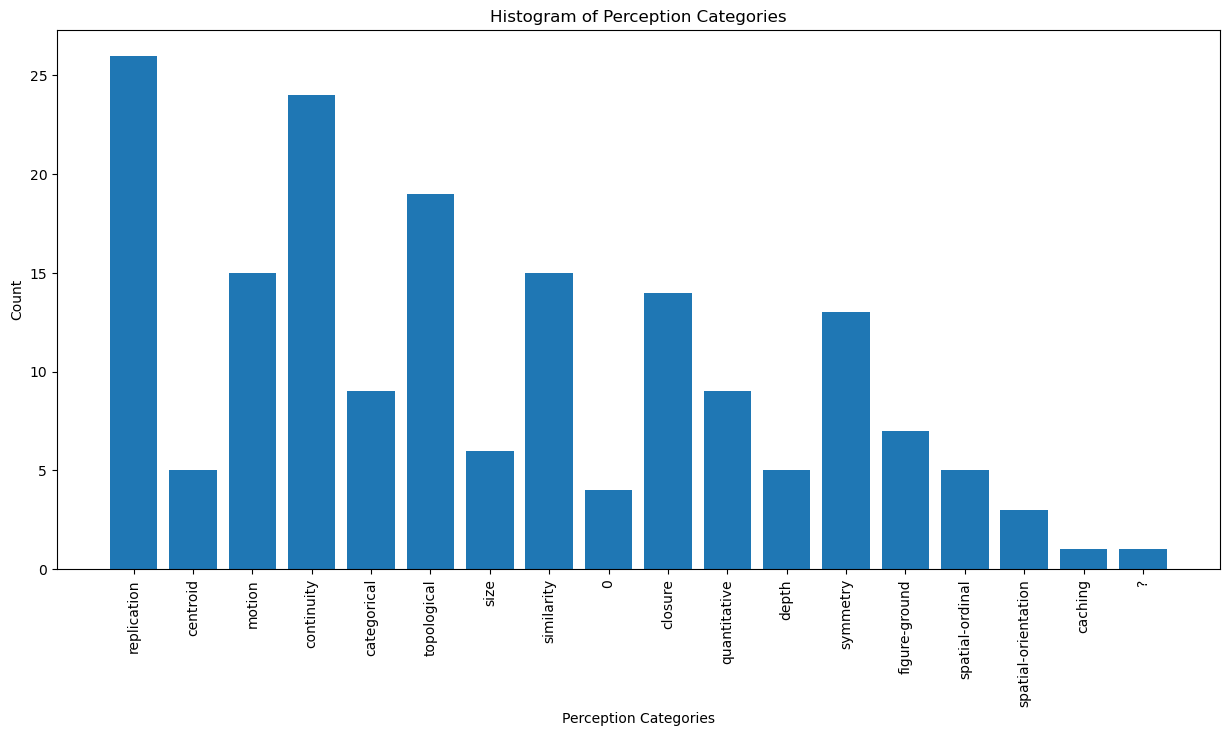

In [8]:
# Flatten the list, including nested lists
def flatten(lst):
    flattened = []
    for item in lst:
        if isinstance(item, list):
            flattened.extend(flatten(item))  # Recursively flatten nested lists
        else:
            flattened.append(item)
    return flattened

# Flatten the list_perceptions
flat_list = flatten(list_perceptions)

# Count occurrences using Counter
counts = Counter(flat_list)

# Display the counts
for item, count in counts.items():
    print(f"{item}: {count}")

# Plot histogram
plt.figure(figsize=(15, 7))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=90)
plt.xlabel('Perception Categories')
plt.ylabel('Count')
plt.title('Histogram of Perception Categories')
plt.show()

In [6]:
# Set the desired working directory
os.chdir("/home/jdelinea/ARC-AGI/BARC")
directory_path = "arc/train_problems"

dic = create_arc_training_tasks(directory_path,list_perceptions)

In [12]:
print(len(dic))

dic

149


{0: {'name': '623ea044',
  'perceptions': 'replication',
  'example': {'train': [{'input': [[0,
       0,
       0,
       0,
       0,
       0,
       0,
       0,
       0,
       0,
       0,
       0,
       0,
       0,
       0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
     'output': [[2, 

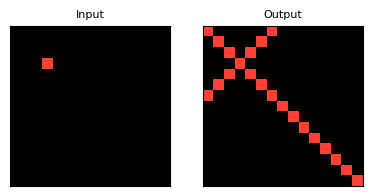

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Provided data
arc_data = {
    'train': [
        {'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
         'output': [[2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]]},
    ]
}

# Extract the input-output pairs for training
train_pairs = [(np.array(ex['input']), np.array(ex['output'])) for ex in arc_data['train']]

# Function to plot the input-output pairs
def plot_arc_input_outputs(input_outputs, column_headings=None, figsize_multiplier=2, show_grid=False, title_fontsize=8):
    column_headings = column_headings or ["input", "output"]
    n_pairs = len(input_outputs)
    n_cols = len(input_outputs[0])

    figure, axs = plt.subplots(n_pairs, n_cols, figsize=(figsize_multiplier * n_cols, figsize_multiplier * n_pairs), dpi=100)

    # Ensure axs is always 2D
    if n_pairs == 1 and n_cols == 1:
        axs = np.array([[axs]])
    elif n_pairs == 1:
        axs = axs[np.newaxis, :]
    elif n_cols == 1:
        axs = axs[:, np.newaxis]

    # Define colors
    colors_rgb = {
        0: (0x00, 0x00, 0x00),
        1: (0x00, 0x74, 0xD9),
        2: (0xFF, 0x41, 0x36),
        3: (0x2E, 0xCC, 0x40),
        4: (0xFF, 0xDC, 0x00),
        5: (0xA0, 0xA0, 0xA0),
        6: (0xF0, 0x12, 0xBE),
        7: (0xFF, 0x85, 0x1B),
        8: (0x7F, 0xDB, 0xFF),
        9: (0x87, 0x0C, 0x25),
        10: (0xFF, 0xFF, 0xFF)
    }

    _float_colors = [tuple(c / 255 for c in col) for col in colors_rgb.values()]
    arc_cmap = ListedColormap(_float_colors)

    for ex, input_output in enumerate(input_outputs):
        for col, grid in enumerate(input_output):
            ax = axs[ex, col]
            grid = grid.T
            ax.pcolormesh(grid, cmap=arc_cmap, rasterized=True, vmin=0, vmax=10)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect('equal')
            ax.invert_yaxis()
            ax.set_title(column_headings[col], fontsize=title_fontsize)

    plt.tight_layout()
    plt.show()

# Plot the input-output pairs
plot_arc_input_outputs(train_pairs, column_headings=["Input", "Output"])
